In [1]:
import warnings
warnings.filterwarnings('ignore')
from pymatch.Matcher import Matcher
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Propensity Score Matching Analysis (pymatch)

Participants with an aggregate score of 4 or 5 vascular risk factors (VRFs) were propensity scored matched on age and sex for those with a score of 0, using the pymatch package for python [1].

In [2]:
data = pd.read_csv('casuality_data_final_factor_analyzer.csv')
data.shape

(2065, 1427)

In [3]:
S0 = data.loc[data['agg_score'] == 0]
S1 = data.loc[data['agg_score'] == 1]
S2 = data.loc[data['agg_score'] == 2]
S3 = data.loc[data['agg_score'] == 3]
S4 = data.loc[data['agg_score'] == 4]
S5 = data.loc[data['agg_score'] == 5]
S0.shape, S1.shape, S2.shape, S3.shape, S4.shape, S5.shape

((523, 1427), (606, 1427), (555, 1427), (273, 1427), (91, 1427), (17, 1427))

In [4]:
S_45 = pd.concat((S4, S5), axis=0)
S_45.shape

(108, 1427)

In [5]:
# Create test and control groups
test_obs = S_45
control_obs = S0

In [6]:
# Covariates to test on
columns=['cardio_cov_sex', 'cardio_cov_age']
test_obs = test_obs[columns]
control_obs = control_obs[columns]

In [7]:
print(test_obs.shape)
print(control_obs.shape)

(108, 2)
(523, 2)


In [8]:
# This step is necessary for the statement in the library
test_obs['agg_score'] = 1
control_obs['agg_score'] = 0

## 1. Distributions before matching

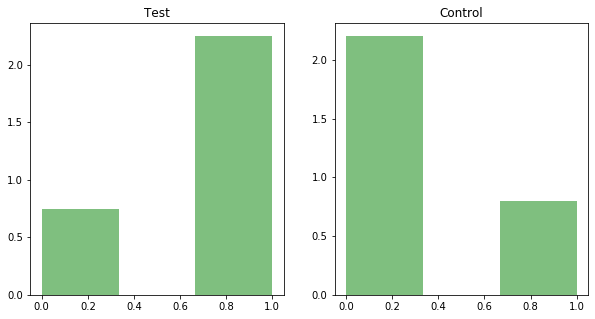

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Test', loc ='center')
n, bins, patches = plt.hist(test_obs["cardio_cov_sex"], 3, density=True, facecolor='g', alpha=0.5)

plt.subplot(1,2,2)
plt.title('Control', loc ='center')
n, bins, patches = plt.hist(control_obs["cardio_cov_sex"], 3, density=True, facecolor='g', alpha=0.5)
plt.show()

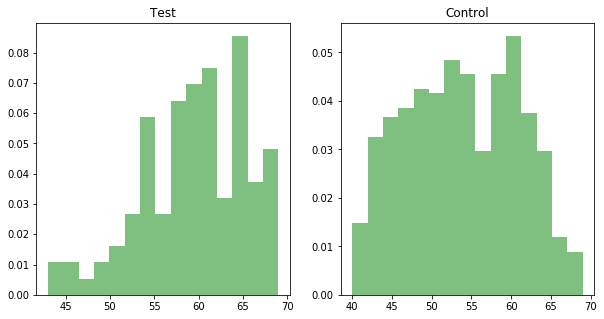

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Test', loc ='center')
n, bins, patches = plt.hist(test_obs["cardio_cov_age"], 15, density=True, facecolor='g', alpha=0.5)

plt.subplot(1,2,2)
plt.title('Control', loc ='center')
n, bins, patches = plt.hist(control_obs["cardio_cov_age"], 15, density=True, facecolor='g', alpha=0.5)
plt.show()

In [11]:
mean_test_sex = test_obs["cardio_cov_sex"].mean()
mean_test_age = test_obs["cardio_cov_age"].mean()
mean_control_sex = control_obs["cardio_cov_sex"].mean()
mean_control_age = control_obs["cardio_cov_age"].mean()

In [12]:
print(str("Test sex mean: " + str(mean_test_sex)))
print(str("Test age mean: " + str(mean_test_age)))
print(str("Control sex mean: " + str(mean_control_sex)))
print(str("Control age mean: " + str(mean_control_age)))

Test sex mean: 0.75
Test age mean: 59.583333333333336
Control sex mean: 0.26577437858508607
Control age mean: 53.79158699808795


## 2. Matching

Initalize the `Matcher` object. 

**Note that:**

* Upon intialization, `Matcher` prints the formula used to fit logistic regression model(s) and the number of records in the majority/minority class. 
    * The regression model(s) are used to generate propensity scores. In this case, we are using the covariates on the right side of the equation to estimate the probability of having 4 or 5 VRFs or none. 
* `Matcher` will use all covariates in the dataset unless a formula is specified by the user. Note that this step is only fitting model(s), we assign propensity scores later. 
* Any covariates passed to the (optional) `exclude` parameter will be ignored from the model fitting process. This parameter is particularly useful for unique identifiers like a `user_id`. 

### `Matcher`

In [13]:
m = Matcher(test_obs, control_obs, yvar="agg_score", exclude=[])

Formula:
agg_score ~ cardio_cov_sex+cardio_cov_age
n majority: 523
n minority: 108


There is a significant imbalance in our data--the majority group (0 VRFs) having many more records than the minority group (4 and 5 VRFs). We account for this by setting `balance=True` when calling `Matcher.fit_scores()` below. This tells `Matcher` to sample from the majority group when fitting the logistic regression model(s) so that the groups are of equal size. When undersampling this way, it is highly recommended that `nmodels` is explictly assigned to a integer much larger than 1. This ensure is that more of the majority group is contributing to the generation of propensity scores. The value of this integer should depend on the severity of the imbalance; here we use `nmodels`=100.

In [14]:
# for reproducibility
np.random.seed(20170925)

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 75.9%


The average accuracy of our 100 models is 75.9%, suggesting that there’s separability within our data and justifying the need for the matching procedure. It’s worth noting that we don’t pay much attention to these logistic models since we are using them as a feature extraction tool (generation of propensity scores). The accuracy is a good way to detect separability at a glance, but we shouldn’t spend time tuning and tinkering with these models. If our accuracy was close to 50%, that would suggest we cannot detect much separability in our groups given the features we observe and that matching is probably not necessary (or more features should be included if possible).

In [15]:
m.predict_scores()

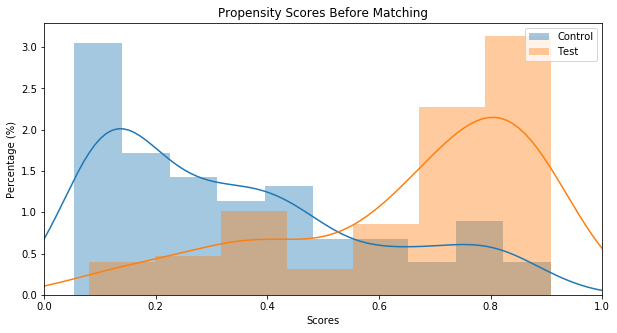

In [16]:
m.plot_scores()

The plot above demonstrates the separability present in our data. Test profiles have a much higher **propensity**, or estimated probability of defaulting given the features we isolated in the data.

### Tune Threshold

The `Matcher.match()` method matches profiles that have propensity scores within some threshold. 

i.e. for two scores `s1` and `s2`, `|s1 - s2|` <= `threshold`

By default matches are found *from* the majority group *for* the minority group. For example, if our test group contains 1,000 records and our control group contains 20,000, `Matcher` will
    iterate through the test (minority) group and find suitable matches from the control (majority) group. If a record in the minority group has no suitable matches, it is dropped from the final matched dataset. We need to ensure our threshold is small enough such that we get close matches and retain most (or all) of our data in the minority group.

### Match Data

Below we match one record from the majority group to each record in the minority group. This is done **with** replacement, meaning a single majority record can be matched to multiple minority records. `Matcher` assigns a unique `record_id` to each record in the test and control groups so this can be addressed after matching. If susequent modelling is planned, one might consider weighting models using a weight vector of 1/`f` for each record, `f` being a record's frequency in the matched dataset. Thankfully `Matcher` can handle all of this for you :).

In [17]:
m.match(method="min", nmatches=1, threshold=0.00001)

In [18]:
m.assign_weight_vector()

Let's take a look at our matched data thus far. Note that in addition to the weight vector, `Matcher` has also assigned a `match_id` to each record indicating our (in this cased) *paired* matches since we use `nmatches=1`. We can verify that matched records have `scores` within 0.00001 of each other. 

In [19]:
match_data = m.matched_data
match_data.shape

(216, 7)

In [20]:
m.matched_data.sort_values("match_id").head(5)

,record_id,weight,cardio_cov_sex,cardio_cov_age,agg_score,scores,match_id
0,0,1.000000,0,64,1,0.455016,0
211,595,0.500000,0,64,0,0.455016,0
193,574,0.142857,1,62,0,0.820240,1
1,1,1.000000,1,62,1,0.820240,1
2,2,1.000000,0,59,1,0.321896,2


### Assess Matches

We must now determine if our data is "balanced". Can we detect any statistical differences between the covariates of our matched test and control groups? `Matcher` is configured to treat categorical and continouous variables separately in this assessment.

___Continuous___

For continous variables we look at Empirical Cumulative Distribution Functions (ECDF) for our test and control groups  before and after matching.

For example, the first plot pair shows:
* ECDF for test vs ECDF for control before matching (left), ECDF for test vs ECDF for control after matching(right). We want the two lines to be very close to each other (or indistiguishable) after matching.
* Some tests + metrics are included in the chart titles.
    * Tests performed:
        * Kolmogorov-Smirnov Goodness of fit Test (KS-test)
            This test statistic is calculated on 1000
            permuted samples of the data, generating
            an imperical p-value.
        * Chi-Square Distance:
            Similarly this distance metric is calculated on 
            1000 permuted samples. 

    * Other included Stats:
        * Standarized mean and median differences.
             How many standard deviations away are the mean/median
            between our groups before and after matching
            i.e. `abs(mean(control) - mean(test))` / `std(control.union(test))`

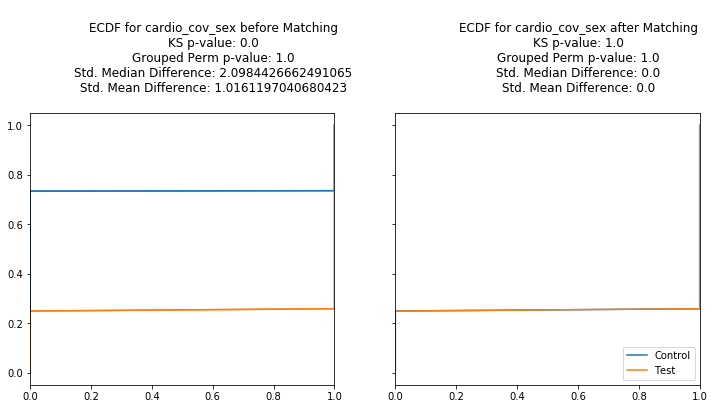

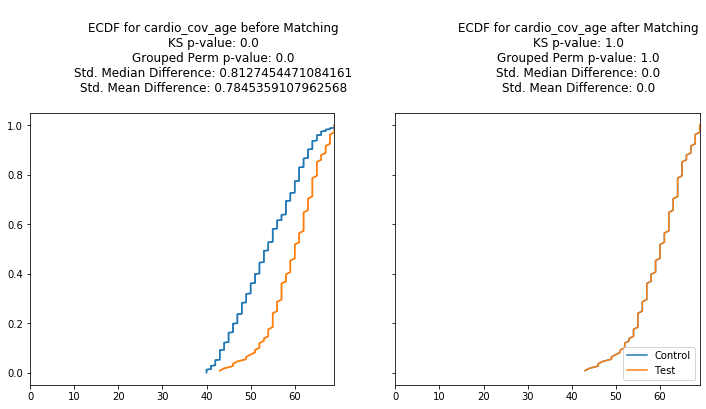

In [21]:
cc = m.compare_continuous(return_table=True)

In [22]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,cardio_cov_sex,0.0,1.0,1.0,1.0,2.098443,0.0,1.016120,0.0
1,cardio_cov_age,0.0,1.0,0.0,1.0,0.812745,0.0,0.784536,0.0


We want the pvalues from both the KS-test and the grouped permutation of the Chi-Square distance after matching to be > 0.05, and they all are! We can verify by looking at how close the ECDFs are between test and control.

## 3. Distributions after matching

In [23]:
test_match = match_data.loc[match_data['agg_score'] == 1]
control_match = match_data.loc[match_data['agg_score'] == 0]
test_match.shape, control_match.shape

((108, 7), (108, 7))

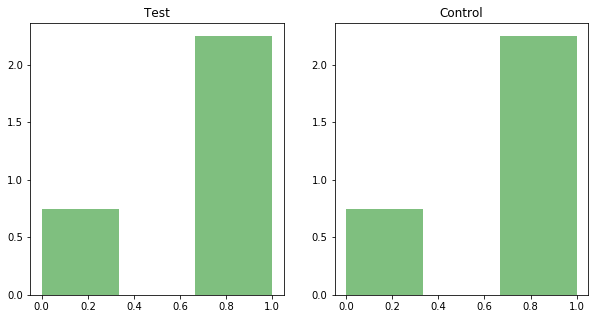

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Test', loc ='center')
n, bins, patches = plt.hist(test_match["cardio_cov_sex"], 3, density=True, facecolor='g', alpha=0.5)

plt.subplot(1,2,2)
plt.title('Control', loc ='center')
n, bins, patches = plt.hist(control_match["cardio_cov_sex"], 3, density=True, facecolor='g', alpha=0.5)
plt.show()

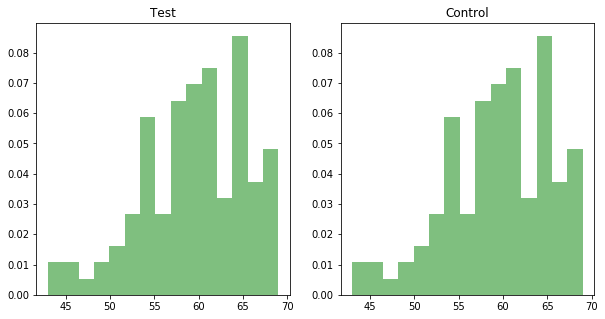

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Test', loc ='center')
n, bins, patches = plt.hist(test_match["cardio_cov_age"], 15, density=True, facecolor='g', alpha=0.5)

plt.subplot(1,2,2)
plt.title('Control', loc ='center')
n, bins, patches = plt.hist(control_match["cardio_cov_age"], 15, density=True, facecolor='g', alpha=0.5)
plt.show()

In [26]:
mean_test_sex = test_match["cardio_cov_sex"].mean()
mean_test_age = test_match["cardio_cov_age"].mean()
mean_control_sex = control_match["cardio_cov_sex"].mean()
mean_control_age = control_match["cardio_cov_age"].mean()

In [27]:
print(str("Test sex mean: " + str(mean_test_sex)))
print(str("Test age mean: " + str(mean_test_age)))
print(str("Control sex mean: " + str(mean_control_sex)))
print(str("Control age mean: " + str(mean_control_age)))

Test sex mean: 0.75
Test age mean: 59.583333333333336
Control sex mean: 0.75
Control age mean: 59.583333333333336


As we can see, we also plotted the mean distributions for age and sex before and after matching, and computed the means for these covariates for both our control and test groups. These results shows us how the matching procedure worked since these distributions are more balanced after applying propensity score matching. In addition, it is also noticeable that before matching, there are more males than females in the test group (patients with four and five VRFs). Furthermore, the age mean for the test group (59.58) before matching is much higher than the control’s group (53.79).

## 4. References

[1]: [Miroglio, Ben (2017)](https://github.com/benmiroglio/pymatch). pymatch

[2]: [Miroglio, Ben (2017)](https://medium.com/@bmiroglio/introducing-the-pymatch-package-6a8c020e2009). Introducing the pymatch Python Package